In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree

#from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import PredictionErrorDisplay

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import seaborn as sns
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.mosaicplot import mosaic
pd.set_option('display.max_columns', 70)

In [3]:
df_hex = pd.read_csv('spb_hex.csv', sep = ',', decimal = ',', index_col = 0)
df_tracks = pd.read_csv('tracks_v2.csv', sep = ';', decimal = ',', index_col = 0)

### Description of Data for `hex`

*   h3_9 - geo mark of a hexagon
*   age_20, age_20_30, age_30_40,	age_40_60,	age_60 - N of people by ages
*   male, female	- N of people by gender, who visited the hexagon
*   car_owners - N of people who owns a car
*   carsharing_user - N of people who used carsharing services in the hexagon
*   not_citizen_rf - N of people who is a foreigner (not a citizen of Russia)
*   public_trnsprt_user	- N of people who uses public transport
*   healthy_food_inter - N of people who eat healthy food
*   salary_1, salary_2, salary_3, salary_4, salary_5 - N of people by salary levels

In [4]:
df_hex.shape

(32422, 18)

In [5]:
df_hex.head(3)

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0


In [6]:
(df_hex.isna().sum() / len(df_hex)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
h3_9,0.00%
age_20,0.00%
age_20_30,0.00%
age_30_40,0.00%
age_40_60,0.00%
age_60,0.00%
male,0.00%
female,0.00%
car_owners,0.00%
carsharing_user,0.00%


## Preprocessing

In [7]:
gender_columns = ['male', 'female']

df_hex['total_gender'] = df_hex[gender_columns].sum(axis=1)

In [8]:
df_hex_original = df_hex.copy()

In [9]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

for age_col in age_columns:
    share_col = age_col + '_share'
    df_hex[share_col] = df_hex[age_col] / df_hex[age_columns].sum(axis=1)

In [10]:
df_hex

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1,12,0.0,0.000000,0.666667,0.250000,0.083333
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1,21,0.0,0.684211,0.157895,0.105263,0.052632
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0.0,0.000000,1.000000,0.000000,0.000000
3,89110615e0fffff,0,2,11,20,15,46,19,14,0,22,1,0,33,12,2,7,4,65,0.0,0.041667,0.229167,0.416667,0.312500
4,892d721010bffff,0,0,2,1,1,3,1,0,0,0,0,0,2,1,0,0,0,4,0.0,0.000000,0.500000,0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32417,8911030ce4bffff,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0.0,0.000000,0.000000,0.000000,1.000000
32418,891106c2bc7ffff,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0.0,0.000000,1.000000,0.000000,0.000000
32419,891160c0693ffff,0,0,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,2,0.0,0.000000,0.000000,0.000000,1.000000
32420,8910a810153ffff,0,0,1,1,0,1,1,2,0,2,0,0,0,1,0,0,1,2,0.0,0.000000,0.500000,0.500000,0.000000


In [11]:
gender_columns = ['male', 'female']

for g_col in gender_columns:
    share_col = g_col + '_share'
    df_hex[share_col] = df_hex[g_col] / df_hex[gender_columns].sum(axis=1)

In [12]:
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

for s_col in salary_columns:
    share_col = s_col + '_share'
    df_hex[share_col] = df_hex[s_col] / df_hex[salary_columns].sum(axis=1)

In [13]:
other_columns = ['car_owners', 'public_trnsprt_user', 'healthy_food_inter', ]

for o_col in other_columns:
    share_col = o_col + '_share'
    df_hex[share_col] = df_hex[o_col] / df_hex['total_gender']

In [14]:
car_columns = ['not_citizen_rf', 'carsharing_user']

for c_col in car_columns:
    share_col = c_col + '_share'
    df_hex[share_col] = df_hex[c_col] / df_hex['total_gender']

In [15]:
df_hex

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1,12,0.0,0.000000,0.666667,0.250000,0.083333,0.583333,0.416667,0.083333,0.500000,0.166667,0.166667,0.083333,0.333333,0.000000,0.0,0.166667,0.416667
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1,21,0.0,0.684211,0.157895,0.105263,0.052632,0.190476,0.809524,0.111111,0.055556,0.777778,0.000000,0.055556,0.761905,0.000000,0.0,0.809524,0.047619
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
3,89110615e0fffff,0,2,11,20,15,46,19,14,0,22,1,0,33,12,2,7,4,65,0.0,0.041667,0.229167,0.416667,0.312500,0.707692,0.292308,0.568966,0.206897,0.034483,0.120690,0.068966,0.215385,0.015385,0.0,0.338462,0.000000
4,892d721010bffff,0,0,2,1,1,3,1,0,0,0,0,0,2,1,0,0,0,4,0.0,0.000000,0.500000,0.250000,0.250000,0.750000,0.250000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32417,8911030ce4bffff,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32418,891106c2bc7ffff,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32419,891160c0693ffff,0,0,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,2,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,1.000000,0.000000
32420,8910a810153ffff,0,0,1,1,0,1,1,2,0,2,0,0,0,1,0,0,1,2,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,1.000000,0.000000,0.0,1.000000,0.000000


In [16]:
columns_to_drop = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60', 
                   'male', 'female', 'car_owners', 'carsharing_user', 
                   'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter', 
                   'salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

df_hex_perc_only = df_hex.drop(columns=columns_to_drop)

In [17]:
df_hex_perc_only

,h3_9,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,8911063244fffff,12,0.0,0.000000,0.666667,0.250000,0.083333,0.583333,0.416667,0.083333,0.500000,0.166667,0.166667,0.083333,0.333333,0.000000,0.0,0.166667,0.416667
1,891106074d7ffff,21,0.0,0.684211,0.157895,0.105263,0.052632,0.190476,0.809524,0.111111,0.055556,0.777778,0.000000,0.055556,0.761905,0.000000,0.0,0.809524,0.047619
2,8911062a87bffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
3,89110615e0fffff,65,0.0,0.041667,0.229167,0.416667,0.312500,0.707692,0.292308,0.568966,0.206897,0.034483,0.120690,0.068966,0.215385,0.015385,0.0,0.338462,0.000000
4,892d721010bffff,4,0.0,0.000000,0.500000,0.250000,0.250000,0.750000,0.250000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32417,8911030ce4bffff,1,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32418,891106c2bc7ffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32419,891160c0693ffff,2,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,1.000000,0.000000
32420,8910a810153ffff,2,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,1.000000,0.000000,0.0,1.000000,0.000000


## Clustering

In [18]:
df_hex_original

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_gender
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1,12
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1,21
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1
3,89110615e0fffff,0,2,11,20,15,46,19,14,0,22,1,0,33,12,2,7,4,65
4,892d721010bffff,0,0,2,1,1,3,1,0,0,0,0,0,2,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32417,8911030ce4bffff,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1
32418,891106c2bc7ffff,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
32419,891160c0693ffff,0,0,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,2
32420,8910a810153ffff,0,0,1,1,0,1,1,2,0,2,0,0,0,1,0,0,1,2


In [20]:
#df_hex_original = df_hex_original.drop(columns=['Clusters'])

In [21]:
df_for_pca = df_hex_original.drop(columns=['h3_9'])

In [22]:
scaler = StandardScaler()
scaler.fit(df_for_pca)
scaled_df_nost = pd.DataFrame(scaler.transform(df_for_pca),columns= df_for_pca.columns )

pca = PCA(n_components=None, random_state = 15).fit(scaled_df_nost)


varExplainedRatio = pca.explained_variance_ratio_
print(varExplainedRatio)
print()
cumulVarExplained = np.cumsum(varExplainedRatio)
cumulVarExplained

[7.04990590e-01 5.15215227e-02 4.42178149e-02 3.61114062e-02
 2.69945935e-02 2.46392150e-02 2.11888515e-02 1.92055508e-02
 1.69489444e-02 1.43475105e-02 1.18060906e-02 1.03207636e-02
 7.83067663e-03 4.69139982e-03 3.07316766e-03 1.65651227e-03
 4.55390013e-04 5.31211650e-33]



array([0.70499059, 0.75651211, 0.80072993, 0.83684133, 0.86383593,
       0.88847514, 0.90966399, 0.92886954, 0.94581849, 0.960166  ,
       0.97197209, 0.98229285, 0.99012353, 0.99481493, 0.9978881 ,
       0.99954461, 1.        , 1.        ])

In [23]:
def varplot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

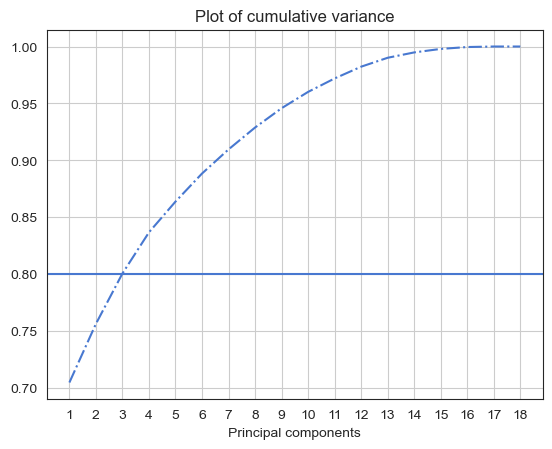

In [24]:
varplot(cumulVarExplained, "cumulative", h=0.8)

Elbow Method for PCA_df_nost


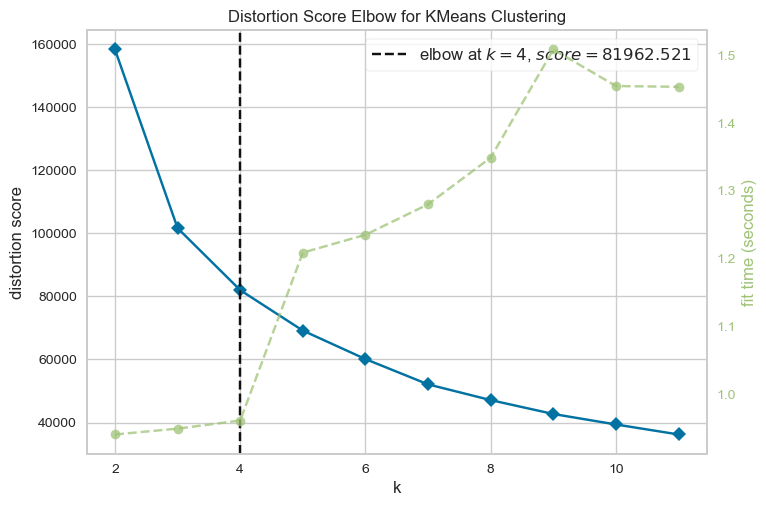

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

pca = PCA(n_components=3, random_state = 14)
pca.fit(scaled_df_nost)
columns_list = ["col" + str(i) for i in range(1, 4)]
PCA_df_nost = pd.DataFrame(pca.transform(scaled_df_nost), columns=(columns_list))

#Смотрим сколько кластеров нужно брать
print('Elbow Method for PCA_df_nost')
Elbow_M = KElbowVisualizer(KMeans(), k=11)
Elbow_M.fit(PCA_df_nost)
Elbow_M.show()

In [26]:
kmeans = KMeans(n_clusters=4, random_state=15)
cluster_kmeans = kmeans.fit_predict(PCA_df_nost)

PCA_df_nost["Clusters"] = cluster_kmeans
df_for_pca["Clusters"] = cluster_kmeans
df_hex_original["Clusters"] = cluster_kmeans

In [27]:
plot_colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
'#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']

In [28]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [29]:
#Функция для инфы ок кластере, смотрим на баланс и на средние значения
def clust_review(dataframe, condition_column, end_value):
    
    pl = sns.countplot(x=dataframe["Clusters"], palette = plot_colors)
    pl.set_title("Distribution Of The Clusters")
    plt.show()
    print(color.BOLD+"MEAN VALUE FOR EACH FEATURE"+color.END)
    mean_values_dict = {}
    count_values_dict = {}
    for condition_value in range(end_value + 1):
        filtered_df = dataframe[dataframe[condition_column] == condition_value]
        mean_values = filtered_df.mean()
        mean_values_dict[condition_value] = mean_values
        count_values_dict[condition_value] = len(filtered_df)
    result_df = pd.DataFrame(mean_values_dict).transpose()
    result_df.index.name = condition_column
    result_df = result_df.drop(condition_column, axis=1)
    result_df['Size of the clusters'] = pd.Series(count_values_dict)
    result_df = result_df.round(2)
    pd.set_option('display.max_columns', 30)
    return result_df

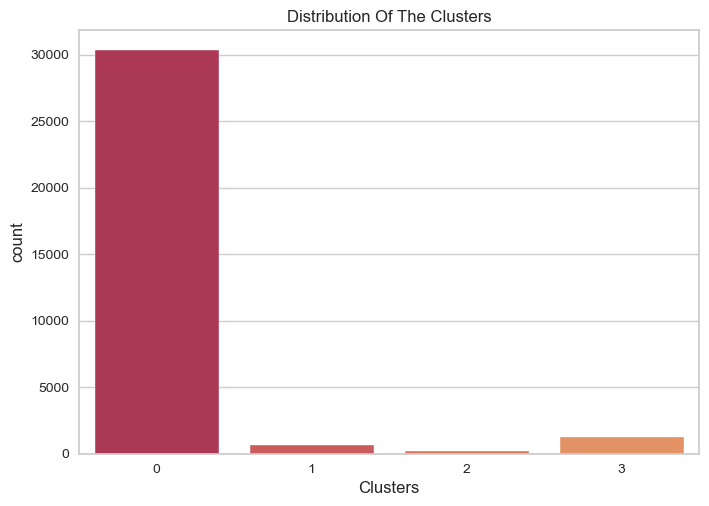

MEAN VALUE FOR EACH FEATURE


,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_gender,Size of the clusters
Clusters,,,,,,,,,,,,,,,,,,,
0,0.11,0.89,2.14,2.92,1.17,4.52,3.39,2.66,0.95,3.97,0.22,0.16,2.30,1.36,1.01,0.84,0.65,7.91,30331
1,6.27,59.51,156.56,213.33,81.80,314.45,244.17,201.34,73.78,279.59,18.81,10.84,165.76,100.60,76.05,59.57,50.56,558.62,630
2,10.19,116.69,285.64,389.27,136.75,569.88,440.83,368.26,141.27,517.51,32.37,23.51,285.92,179.63,144.77,107.11,95.53,1010.71,204
3,2.29,28.83,69.05,95.23,38.21,140.86,111.37,86.34,31.70,128.21,6.66,4.63,73.87,46.08,34.63,25.87,21.16,252.22,1257


In [30]:
clust_review(df_hex_original, 'Clusters', 3)

## Clustering Shares attempt

In [42]:
df_hex_perc_only

,h3_9,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,8911063244fffff,12,0.0,0.000000,0.666667,0.250000,0.083333,0.583333,0.416667,0.083333,0.500000,0.166667,0.166667,0.083333,0.333333,0.000000,0.0,0.166667,0.416667
1,891106074d7ffff,21,0.0,0.684211,0.157895,0.105263,0.052632,0.190476,0.809524,0.111111,0.055556,0.777778,0.000000,0.055556,0.761905,0.000000,0.0,0.809524,0.047619
2,8911062a87bffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
3,89110615e0fffff,65,0.0,0.041667,0.229167,0.416667,0.312500,0.707692,0.292308,0.568966,0.206897,0.034483,0.120690,0.068966,0.215385,0.015385,0.0,0.338462,0.000000
4,892d721010bffff,4,0.0,0.000000,0.500000,0.250000,0.250000,0.750000,0.250000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32417,8911030ce4bffff,1,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32418,891106c2bc7ffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
32419,891160c0693ffff,2,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,1.000000,0.000000
32420,8910a810153ffff,2,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,1.000000,0.000000,0.0,1.000000,0.000000


In [43]:
df_hex_perc_only = df_hex_perc_only.fillna(0)

In [44]:
df_for_pca = df_hex_perc_only.drop(columns=['h3_9'])

In [45]:
scaler = StandardScaler()
scaler.fit(df_for_pca)
scaled_df_nost = pd.DataFrame(scaler.transform(df_for_pca),columns= df_for_pca.columns )

pca = PCA(n_components=None, random_state = 15).fit(scaled_df_nost)


varExplainedRatio = pca.explained_variance_ratio_
print(varExplainedRatio)
print()
cumulVarExplained = np.cumsum(varExplainedRatio)
cumulVarExplained

[0.11761187 0.10206754 0.08285911 0.07392514 0.06862697 0.06479095
 0.06273512 0.06192242 0.05899734 0.05645838 0.05408441 0.05277972
 0.04582755 0.04191136 0.03522919 0.01394587 0.0045433  0.00168374]



array([0.11761187, 0.21967941, 0.30253852, 0.37646366, 0.44509064,
       0.50988159, 0.5726167 , 0.63453912, 0.69353647, 0.74999485,
       0.80407926, 0.85685898, 0.90268653, 0.94459789, 0.97982708,
       0.99377295, 0.99831626, 1.        ])

In [46]:
def varplot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

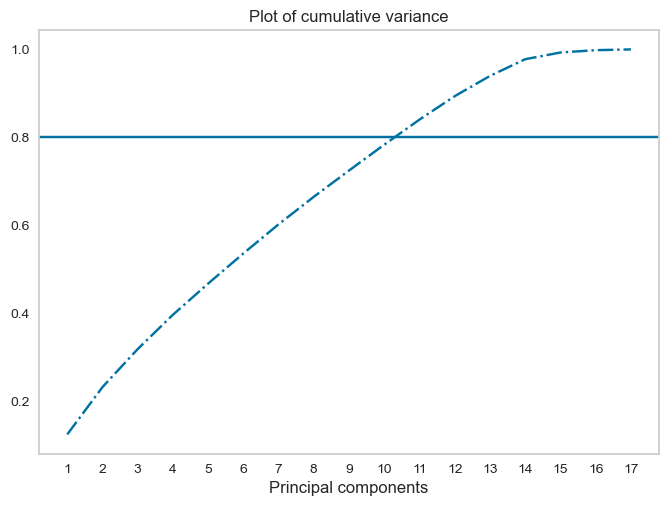

In [76]:
varplot(cumulVarExplained, "cumulative", h=0.8)

Elbow Method for PCA_df_nost


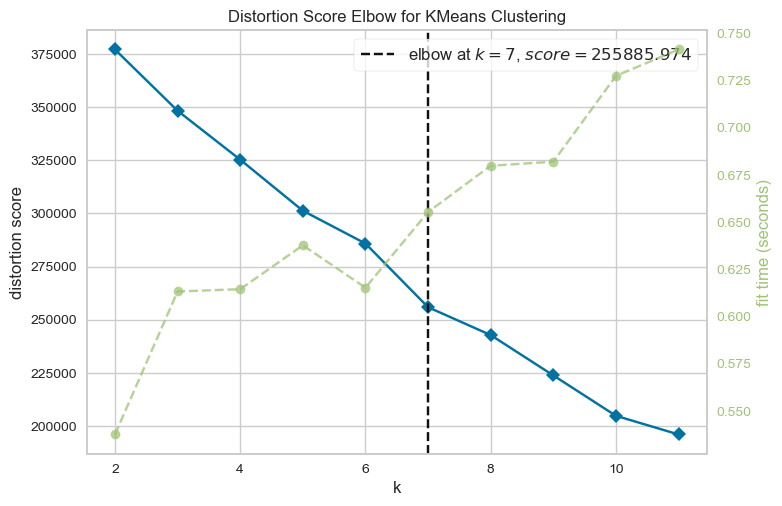

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

pca = PCA(n_components=10, random_state = 14)
pca.fit(scaled_df_nost)
columns_list = ["col" + str(i) for i in range(1, 11)]
PCA_df_nost = pd.DataFrame(pca.transform(scaled_df_nost), columns=(columns_list))

#Смотрим сколько кластеров нужно брать
print('Elbow Method for PCA_df_nost')
Elbow_M = KElbowVisualizer(KMeans(), k=11)
Elbow_M.fit(PCA_df_nost)
Elbow_M.show()

In [79]:
kmeans = KMeans(n_clusters=7, random_state=15)
cluster_kmeans = kmeans.fit_predict(PCA_df_nost)

PCA_df_nost["Clusters"] = cluster_kmeans
df_for_pca["Clusters"] = cluster_kmeans
df_hex_perc_only["Clusters"] = cluster_kmeans

In [80]:
plot_colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
'#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']

In [81]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [82]:
#Функция для инфы ок кластере, смотрим на баланс и на средние значения
def clust_review(dataframe, condition_column, end_value):
    
    pl = sns.countplot(x=dataframe["Clusters"], palette = plot_colors)
    pl.set_title("Distribution Of The Clusters")
    plt.show()
    print(color.BOLD+"MEAN VALUE FOR EACH FEATURE"+color.END)
    mean_values_dict = {}
    count_values_dict = {}
    for condition_value in range(end_value + 1):
        filtered_df = dataframe[dataframe[condition_column] == condition_value]
        mean_values = filtered_df.mean()
        mean_values_dict[condition_value] = mean_values
        count_values_dict[condition_value] = len(filtered_df)
    result_df = pd.DataFrame(mean_values_dict).transpose()
    result_df.index.name = condition_column
    result_df = result_df.drop(condition_column, axis=1)
    result_df['Size of the clusters'] = pd.Series(count_values_dict)
    result_df = result_df.round(2)
    pd.set_option('display.max_columns', 30)
    return result_df

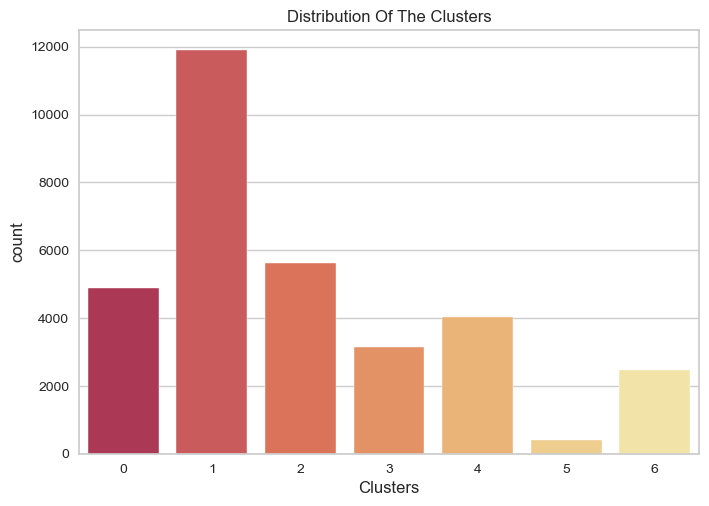

MEAN VALUE FOR EACH FEATURE


,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,carsharing_user_share,public_trnsprt_user_share,healthy_food_inter_share,Size of the clusters
Clusters,,,,,,,,,,,,,,,,,,
0,14.81,0.00,0.09,0.29,0.42,0.17,0.58,0.42,0.04,0.90,0.02,0.02,0.02,0.33,0.11,0.02,0.02,4876
1,73.43,0.00,0.13,0.30,0.37,0.06,0.83,0.12,0.34,0.07,0.22,0.05,0.04,0.28,0.09,0.01,0.01,11892
2,15.58,0.00,0.08,0.28,0.52,0.05,0.10,0.90,0.38,0.05,0.30,0.04,0.03,0.33,0.12,0.03,0.01,5623
3,7.62,0.00,0.20,0.33,0.40,0.05,0.55,0.45,0.07,0.03,0.02,0.87,0.01,0.57,0.29,0.12,0.04,3138
4,9.28,0.00,0.07,0.18,0.05,0.70,0.34,0.66,0.79,0.03,0.01,0.03,0.01,0.16,0.04,0.01,0.02,4038
5,7.76,0.89,0.02,0.04,0.04,0.02,0.63,0.37,0.32,0.19,0.08,0.12,0.09,0.44,0.14,0.10,0.04,390
6,7.15,0.00,0.20,0.36,0.36,0.04,0.62,0.38,0.05,0.03,0.02,0.01,0.89,0.62,0.33,0.04,0.09,2465


In [85]:
clust_review(df_hex_perc_only, 'Clusters', 6)

## Model

In [91]:
df_hex_perc_only.total_gender.max()

1812

In [143]:
df_hex_perc_only

,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,carsharing_user_share,public_trnsprt_user_share,healthy_food_inter_share,Clusters,total_groups
h3_9,,,,,,,,,,,,,,,,,,,
8911063244fffff,12,0.0,0.000000,0.666667,0.250000,0.083333,0.583333,0.416667,0.083333,0.500000,0.166667,0.166667,0.083333,0.333333,0.416667,0.000000,0.0,0,11-50
891106074d7ffff,21,0.0,0.684211,0.157895,0.105263,0.052632,0.190476,0.809524,0.111111,0.055556,0.777778,0.000000,0.055556,0.761905,0.047619,0.000000,0.0,2,11-50
8911062a87bffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,1,1-5
89110615e0fffff,65,0.0,0.041667,0.229167,0.416667,0.312500,0.707692,0.292308,0.568966,0.206897,0.034483,0.120690,0.068966,0.215385,0.000000,0.015385,0.0,1,50+
892d721010bffff,4,0.0,0.000000,0.500000,0.250000,0.250000,0.750000,0.250000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,1-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911030ce4bffff,1,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4,1-5
891106c2bc7ffff,1,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,1-5
891160c0693ffff,2,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4,1-5


In [139]:
df_hex_perc_only = df_hex_perc_only[df_hex_perc_only['total_gender'] > 0]

In [140]:
df_hex_perc_only.shape

(31897, 19)

In [144]:
df_hex_perc_only = df_hex_perc_only.drop(columns=['total_groups'])

In [ ]:
df_hex_perc_only

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df_hex_perc_only.set_index('h3_9', inplace=True)  # Make 'h3_9' the index

In [145]:
# Creating features (X) and target variable (y)
X = df_hex_perc_only.drop(columns=['total_gender'])
y = df_hex_perc_only['total_gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_reg_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()
gradient_boosting_model = GradientBoostingRegressor()

linear_reg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

y_pred_linear_reg = linear_reg_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)

mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)

mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)

mse_gradient_boosting = mean_squared_error(y_test, y_pred_gradient_boosting)
mae_gradient_boosting = mean_absolute_error(y_test, y_pred_gradient_boosting)

mape_linear_reg = (abs(y_test - y_pred_linear_reg) / (y_test + epsilon)) * 100
mape_decision_tree = (abs(y_test - y_pred_decision_tree) / (y_test + epsilon)) * 100
mape_gradient_boosting = (abs(y_test - y_pred_gradient_boosting) / (y_test + epsilon)) * 100


# Displaying metrics
print("Linear Regression Metrics:")
print(f"MSE: {mse_linear_reg}")
print(f"MAE: {mae_linear_reg}")

print("\nDecision Tree Metrics:")
print(f"MSE: {mse_decision_tree}")
print(f"MAE: {mae_decision_tree}")

print("\nGradient Boosting Metrics:")
print(f"MSE: {mse_gradient_boosting}")
print(f"MAE: {mae_gradient_boosting}")
print('MAPE:', mape_gradient_boosting.mean())

feature_importance_linear_reg = pd.Series(linear_reg_model.coef_, index=X.columns)
feature_importance_decision_tree = pd.Series(decision_tree_model.feature_importances_, index=X.columns)
feature_importance_gradient_boosting = pd.Series(gradient_boosting_model.feature_importances_, index=X.columns)

print("\nLinear Regression Feature Importance:")
print(feature_importance_linear_reg.sort_values(ascending=False))

print("\nDecision Tree Feature Importance:")
print(feature_importance_decision_tree.sort_values(ascending=False))

print("\nGradient Boosting Feature Importance:")
print(feature_importance_gradient_boosting.sort_values(ascending=False))

Linear Regression Metrics:
MSE: 12484.604047172465
MAE: 52.48372549651296

Decision Tree Metrics:
MSE: 9200.447616724829
MAE: 25.920481657968224

Gradient Boosting Metrics:
MSE: 4066.3282280693193
MAE: 21.801736563379517
MAPE: 192.22784333583022

Linear Regression Feature Importance:
salary_5_share               183.526874
age_20_share                 122.945790
salary_4_share                73.428893
age_60_share                  60.197617
salary_1_share                48.505826
salary_3_share                23.951426
age_30_40_share               16.323084
age_20_30_share               16.079403
healthy_food_inter_share      12.745294
female_share                  11.491628
age_40_60_share               11.459839
public_trnsprt_user_share      5.203169
carsharing_user_share          1.441604
car_owners_share              -6.371260
male_share                   -11.491628
salary_2_share               -27.975193
Clusters                     -35.715893
dtype: float64

Decision Tree Featu

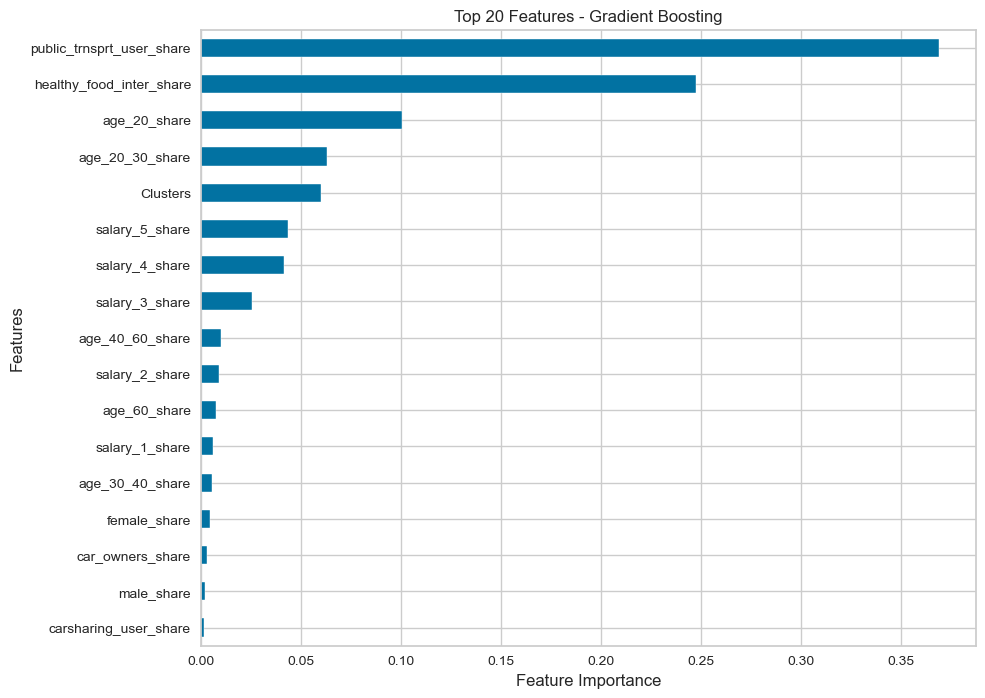

In [104]:
top_features = feature_importance_gradient_boosting.sort_values(ascending=True).head(20)

# Creating a horizontal bar plot
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh')
plt.title('Top 20 Features - Gradient Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [107]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gradient_boosting})

In [108]:
result_df[result_df['Actual'] > 10]

,Actual,Predicted
h3_9,,
891106a8037ffff,810,387.944530
891181b02c3ffff,60,0.531240
8911060d0b7ffff,35,75.918206
891106d32cfffff,107,69.479715
89110607223ffff,43,96.852191
...,...,...
89110600d07ffff,29,99.530957
89110481247ffff,27,113.589661
892d7288b63ffff,15,17.674819


In [109]:
result_df.shape

(6485, 2)

In [105]:
result_df['Actual'] = y_test
result_df['Predicted'] = y_pred_gradient_boosting

# Creating groups based on actual values
group_1 = result_df[result_df['Actual'] < 50]
group_2 = result_df[(result_df['Actual'] >= 50) & (result_df['Actual'] < 150)]
group_3 = result_df[(result_df['Actual'] >= 150) & (result_df['Actual'] < 500)]
group_4 = result_df[result_df['Actual'] >= 500]


def calculate_mape(actual, predicted):
    return (abs(actual - predicted) / actual) * 100


mape_group_1 = calculate_mape(group_1['Actual'], group_1['Predicted'])
mape_group_2 = calculate_mape(group_2['Actual'], group_2['Predicted'])
mape_group_3 = calculate_mape(group_3['Actual'], group_3['Predicted'])
mape_group_4 = calculate_mape(group_4['Actual'], group_4['Predicted'])


print("MAPE for Group 1 (Actual < 50):", mape_group_1.mean())
print("Group 1 Size:", len(group_1))

print("\nMAPE for Group 2 (50 <= Actual < 150):", mape_group_2.mean())
print("Group 2 Size:", len(group_2))

print("\nMAPE for Group 3 (150 <= Actual < 500):", mape_group_3.mean())
print("Group 3 Size:", len(group_3))

print("\nMAPE for Group 4 (Actual >= 500):", mape_group_4.mean())
print("Group 4 Size:", len(group_4))

MAPE for Group 1 (Actual < 50): inf
Group 1 Size: 5875

MAPE for Group 2 (50 <= Actual < 150): 104.39496481085231
Group 2 Size: 215

MAPE for Group 3 (150 <= Actual < 500): 36.50645970588522
Group 3 Size: 275

MAPE for Group 4 (Actual >= 500): 37.38584986418742
Group 4 Size: 120


In [112]:
# Creating features (X) and target variable (y)
X = df_hex_perc_only.drop(columns=['total_gender'])
y = df_hex_perc_only['total_gender']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing models
linear_reg_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()
gradient_boosting_model = GradientBoostingRegressor()

# Training models
linear_reg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

# Making predictions
y_pred_linear_reg = linear_reg_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)

# Evaluating models
mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)

mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)

mse_gradient_boosting = mean_squared_error(y_test, y_pred_gradient_boosting)
mae_gradient_boosting = mean_absolute_error(y_test, y_pred_gradient_boosting)

epsilon = 1e-10  # Small epsilon value to avoid division by zero

mape_linear_reg = (abs(y_test - y_pred_linear_reg) / (y_test + epsilon)) * 100
mape_decision_tree = (abs(y_test - y_pred_decision_tree) / (y_test + epsilon)) * 100
mape_gradient_boosting = (abs(y_test - y_pred_gradient_boosting) / (y_test + epsilon)) * 100
mape_gradient_boosting.replace([np.inf, -np.inf], np.nan, inplace=True)

r2_linear_reg = linear_reg_model.score(X_test, y_test)
r2_decision_tree = decision_tree_model.score(X_test, y_test)
r2_gradient_boosting = gradient_boosting_model.score(X_test, y_test)


# Displaying metrics
print("Linear Regression Metrics:")
print(f"MSE: {mse_linear_reg}")
print(f"MAE: {mae_linear_reg}")

print("\nDecision Tree Metrics:")
print(f"MSE: {mse_decision_tree}")
print(f"MAE: {mae_decision_tree}")

print("\nGradient Boosting Metrics:")
print(f"MSE: {mse_gradient_boosting}")
print(f"MAE: {mae_gradient_boosting}")
print('R2:', r2_gradient_boosting)

# Displaying most relevant features
feature_importance_linear_reg = pd.Series(linear_reg_model.coef_, index=X.columns)
feature_importance_decision_tree = pd.Series(decision_tree_model.feature_importances_, index=X.columns)
feature_importance_gradient_boosting = pd.Series(gradient_boosting_model.feature_importances_, index=X.columns)

print("\nLinear Regression Feature Importance:")
print(feature_importance_linear_reg.sort_values(ascending=False))

print("\nDecision Tree Feature Importance:")
print(feature_importance_decision_tree.sort_values(ascending=False))

print("\nGradient Boosting Feature Importance:")
print(feature_importance_gradient_boosting.sort_values(ascending=False))

Linear Regression Metrics:
MSE: 13496.57427145361
MAE: 53.46115321842338

Decision Tree Metrics:
MSE: 9375.705794803749
MAE: 26.259063035938105

Gradient Boosting Metrics:
MSE: 4303.868912971247
MAE: 20.941818267428545
R2: 0.706037244334589

Linear Regression Feature Importance:
salary_5_share               181.160230
age_20_share                 118.094913
salary_4_share                71.864343
age_60_share                  59.794227
salary_1_share                47.954567
female_share                  25.533155
salary_3_share                24.288714
age_30_40_share               16.157198
age_20_30_share               15.147535
healthy_food_inter_share      13.291985
age_40_60_share               10.561693
public_trnsprt_user_share      4.764832
male_share                     3.030023
carsharing_user_share          1.481984
car_owners_share              -5.178105
salary_2_share               -28.155364
Clusters                     -35.148920
dtype: float64

Decision Tree Feature Im

In [117]:
df_hex_perc_only.shape

(32422, 18)

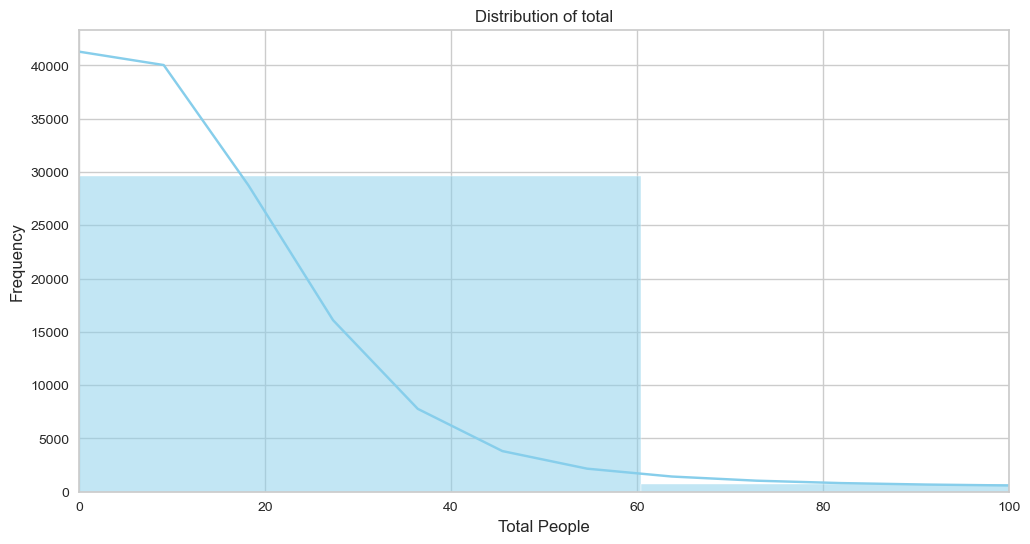

In [116]:
plt.figure(figsize=(12, 6))
sns.histplot(df_hex_perc_only['total_gender'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of total')
plt.xlabel('Total People')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Set x-axis range from 0 to 500
plt.show()

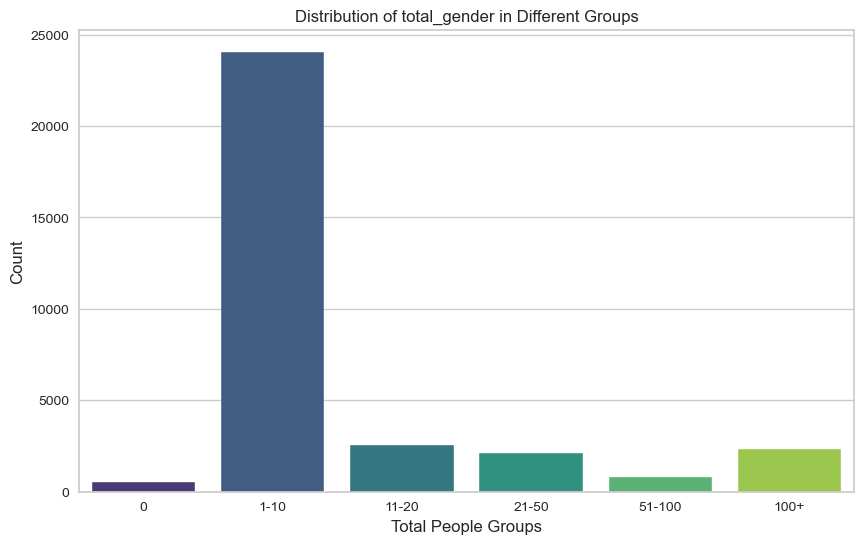

In [118]:
bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
group_labels = ['0', '5-10', '11-20', '21-50', '51-100', '100+']

# Adding a new column 'total_groups' to df_hex_perc_only based on the bins
df_hex_perc_only['total_groups'] = pd.cut(df_hex_perc_only['total_gender'], bins=bins, labels=group_labels, right=False)

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='total_groups', data=df_hex_perc_only, palette='viridis')
plt.title('Distribution of Total in Different Groups')
plt.xlabel('Groups Label')
plt.ylabel('Count')
plt.show()

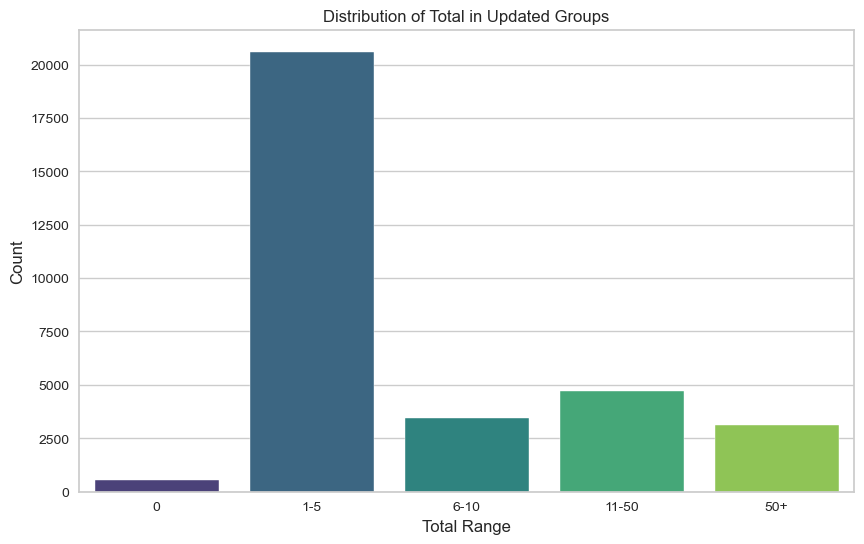

In [120]:
bins = [0, 1, 5, 10, 50, float('inf')]
group_labels = ['0', '1-5', '6-10', '11-50', '50+']

# Adding a new column 'total_groups' to df_hex_perc_only based on the updated bins
df_hex_perc_only['total_groups'] = pd.cut(df_hex_perc_only['total_gender'], bins=bins, labels=group_labels, right=False)

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='total_groups', data=df_hex_perc_only, palette='viridis')
plt.title('Distribution of Total in Updated Groups')
plt.xlabel('Total Range')
plt.ylabel('Count')
plt.show()

## Model 2

**Только для гексов м 5+ посещениями**

In [122]:
df_hex_perc_only.total_gender.value_counts()

1       12743
2        4169
3        2221
4        1469
5        1060
        ...  
991         1
763         1
467         1
643         1
1430        1
Name: total_gender, Length: 861, dtype: int64

In [123]:
df_hex_perc_only_big = df_hex_perc_only[df_hex_perc_only['total_gender'] > 5]

In [129]:
df_hex_perc_only.shape

(32422, 19)

In [146]:
df_hex_perc_only_big

,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,carsharing_user_share,public_trnsprt_user_share,healthy_food_inter_share,Clusters
h3_9,,,,,,,,,,,,,,,,,,
89110615e0fffff,65,0.000000,0.041667,0.229167,0.416667,0.312500,0.707692,0.292308,0.568966,0.206897,0.034483,0.120690,0.068966,0.215385,0.000000,0.015385,0.000000,1
89110604b47ffff,284,0.003571,0.314286,0.242857,0.189286,0.250000,0.369718,0.630282,0.527076,0.187726,0.086643,0.039711,0.158845,0.447183,0.404930,0.250000,0.028169,1
89110602883ffff,284,0.000000,0.210728,0.203065,0.429119,0.157088,0.552817,0.447183,0.245614,0.236842,0.096491,0.267544,0.153509,0.214789,0.049296,0.003521,0.003521,1
89110606b67ffff,386,0.067885,0.148825,0.167102,0.472585,0.143603,0.354922,0.645078,0.418462,0.083077,0.178462,0.178462,0.141538,0.541451,0.186528,0.064767,0.002591,2
8911062821bffff,101,0.010101,0.020202,0.212121,0.474747,0.282828,0.445545,0.554455,0.768293,0.085366,0.024390,0.012195,0.109756,0.079208,0.009901,0.000000,0.009901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911ae34e0fffff,94,0.000000,0.021277,0.000000,0.978723,0.000000,0.978723,0.021277,0.000000,1.000000,0.000000,0.000000,0.000000,0.978723,0.000000,0.000000,0.000000,0
8911aa44087ffff,66,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3
891103b82afffff,58,0.000000,0.000000,0.982759,0.017241,0.000000,0.982759,0.017241,0.000000,0.982759,0.000000,0.017241,0.000000,0.017241,0.982759,0.000000,0.000000,0


In [124]:
df_hex_perc_only_big.shape

(10235, 19)

In [127]:
df_hex_perc_only_big = df_hex_perc_only_big.drop('total_groups', axis=1)

In [138]:
# Creating features (X) and target variable (y)
X = df_hex_perc_only_big.drop(columns=['total_gender'])
y = df_hex_perc_only_big['total_gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()
gradient_boosting_model = GradientBoostingRegressor()

linear_reg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

y_pred_linear_reg = linear_reg_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)

mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)

mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)

mse_gradient_boosting = mean_squared_error(y_test, y_pred_gradient_boosting)
mae_gradient_boosting = mean_absolute_error(y_test, y_pred_gradient_boosting)

mape_gradient_boosting = (abs(y_test - y_pred_gradient_boosting) / y_test) * 100

r2_linear_reg = linear_reg_model.score(X_test, y_test)
r2_decision_tree = decision_tree_model.score(X_test, y_test)
r2_gradient_boosting = gradient_boosting_model.score(X_test, y_test)


print("Linear Regression Metrics:")
print(f"MSE: {mse_linear_reg}")
print(f"MAE: {mae_linear_reg}")

print("\nDecision Tree Metrics:")
print(f"MSE: {mse_decision_tree}")
print(f"MAE: {mae_decision_tree}")

print("\nGradient Boosting Metrics:")
print(f"MSE: {mse_gradient_boosting}")
print(f"MAE: {mae_gradient_boosting}")
print('MAPE:', mape_gradient_boosting.mean())

feature_importance_linear_reg = pd.Series(linear_reg_model.coef_, index=X.columns)
feature_importance_decision_tree = pd.Series(decision_tree_model.feature_importances_, index=X.columns)
feature_importance_gradient_boosting = pd.Series(gradient_boosting_model.feature_importances_, index=X.columns)

print("\nLinear Regression Feature Importance:")
print(feature_importance_linear_reg.sort_values(ascending=False))

print("\nDecision Tree Feature Importance:")
print(feature_importance_decision_tree.sort_values(ascending=False))

print("\nGradient Boosting Feature Importance:")
print(feature_importance_gradient_boosting.sort_values(ascending=False))

Linear Regression Metrics:
MSE: 64715.615491141
MAE: 191.3542100996843

Decision Tree Metrics:
MSE: 68727.02785630945
MAE: 178.51790522347872

Gradient Boosting Metrics:
MSE: 38000.114033866004
MAE: 139.08269528902014
MAPE: 75.59418260191616

Linear Regression Feature Importance:
salary_5_share               337.675800
age_20_share                 250.641051
salary_1_share               241.418298
salary_4_share               232.646421
healthy_food_inter_share     194.045615
salary_3_share               147.363317
age_60_share                 123.259306
age_30_40_share               88.587169
age_40_60_share               79.815944
salary_2_share                56.288485
age_20_30_share               55.981973
carsharing_user_share         42.211754
public_trnsprt_user_share     42.205681
female_share                  39.773036
car_owners_share              18.950204
male_share                   -39.773036
Clusters                     -77.788498
dtype: float64

Decision Tree Feature I